In [1]:
import pandas as pd
import numpy as np


## Linear Regression
- Stock Price

In [23]:
freq = 'Weekly'
stock = 'JNJ'
price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
price = price.sort_values(by='Date').reset_index(drop=True)
price = price.loc[price.Date>='2010-01-01']
predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv',index_col='Date')
#NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv').set_index(['Date'])
#predictors = predictors.merge(NLP,left_index=True,right_index=True,how='left')
predictors = predictors.loc[predictors.index<='2019-12-31',:]
predictors.fillna(0,inplace=True)
#predictors = predictors.drop(['gdp','adjusted_close'],axis=1)
X = predictors.values[:-1,]
y = price.adjusted_close.shift(-1).values[:len(X)]


In [24]:
from sklearn.linear_model import LassoCV,LassoLarsCV,Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,mean_squared_error
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore",category=ConvergenceWarning)

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)

In [26]:
def mse(y_pred, y_true):
    n = len(y_pred)
    return np.sqrt(np.sum(np.square(y_pred - y_true)))/n

- Train LassoCV

In [27]:
scores = []
for i in range(3,15):
    tscv = TimeSeriesSplit(n_splits=i)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
    pipe = make_pipeline(MinMaxScaler(),Lasso())

    sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select='auto',scoring='neg_root_mean_squared_error')
    sfs.fit(X_train,y_train)
    X_train = sfs.transform(X_train)
    pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
    pipmodel.fit(X_train,y_train)
    X_test =  sfs.transform(X_test)
    y_pred = pipmodel.predict(X_train)
    score = mean_squared_error(y_pred, y_train)
    print(score)
    scores.append(score)
n_split = scores.index(min(scores))+2


2.9908736426807487
2.917732205934887
2.852509007009556
2.852509007009556
2.852509007009556
2.876297983220699
2.857324923039651
2.852509007009556
2.89267032568183
2.8628635246879157
2.869227466483496
2.857324923039651


- Results

17.482071471417047 1.724449778628686


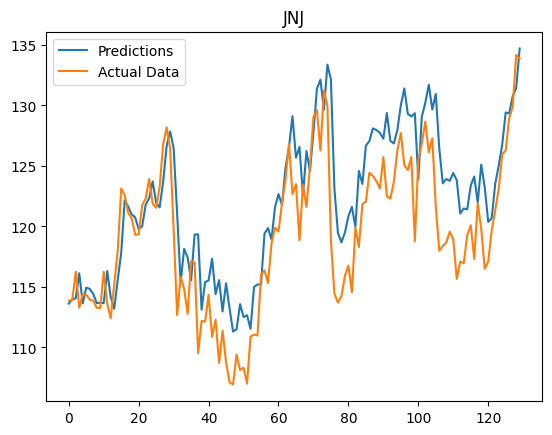

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
tscv = TimeSeriesSplit(n_splits=n_split)
pipe = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=6,scoring='neg_root_mean_squared_error')
sfs.fit(X_train,y_train)
X_train = sfs.transform(X_train)
pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
pipmodel.fit(X_train,y_train)
X_test =  sfs.transform(X_test)
y_pred = pipmodel.predict(X_test)
print(mean_squared_error(y_pred, y_test), mean_squared_error(y_train, pipmodel.predict(X_train)))
plt.plot(y_pred,label="Predictions")
plt.plot(y_test,label="Actual Data")
plt.title(stock)
plt.legend()

In [284]:
total_scores_cv = []
for cv in range(3,15):

    tscv = TimeSeriesSplit(n_splits=cv)
    total_score = []
    for i in range(6,42,6):
        scores = []
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            pipe = make_pipeline(MinMaxScaler(),Lasso())
            sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=i,scoring='neg_root_mean_squared_error')
            sfs.fit(X_train,y_train)
            X_train = sfs.transform(X_train)

            pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
            pipmodel.fit(X_train,y_train)
            X_test =  sfs.transform(X_test)
            y_pred = pipmodel.predict(X_test)
            scores.append(mean_squared_error(y_pred,y_test,squared=False))
        average_score = np.mean(scores)
        print(average_score)
        total_score.append(average_score)
    total_scores_cv.append(total_score)
    print(stock,'/',freq,'\n','MSE', total_score)

print(np.array(total_scores_cv))


4.102437894991296
4.098139989220873
4.100626115767068
3.041730503475113
32.663108451670844
57.10774130795449
GOOG / Daily 
 MSE [4.102437894991296, 4.098139989220873, 4.100626115767068, 3.041730503475113, 32.663108451670844, 57.10774130795449]
2.788976214468153
2.7906286772502265
2.817946598321018
2.4423391918239474
12.891182926949744
6.693553851303111
GOOG / Daily 
 MSE [2.788976214468153, 2.7906286772502265, 2.817946598321018, 2.4423391918239474, 12.891182926949744, 6.693553851303111]
2.2056864322132173
2.204391869519382
2.202943369237873
1.8589032459954933
5.175031791455572
4.44828871710382
GOOG / Daily 
 MSE [2.2056864322132173, 2.204391869519382, 2.202943369237873, 1.8589032459954933, 5.175031791455572, 4.44828871710382]
2.85871369999278
2.853782999283112
2.8947373056225945
2.3306819373506755
2.4510830262089462
7.052885385292911
GOOG / Daily 
 MSE [2.85871369999278, 2.853782999283112, 2.8947373056225945, 2.3306819373506755, 2.4510830262089462, 7.052885385292911]
2.3451900427705334

0.07852144648892097 0.030673569349833146


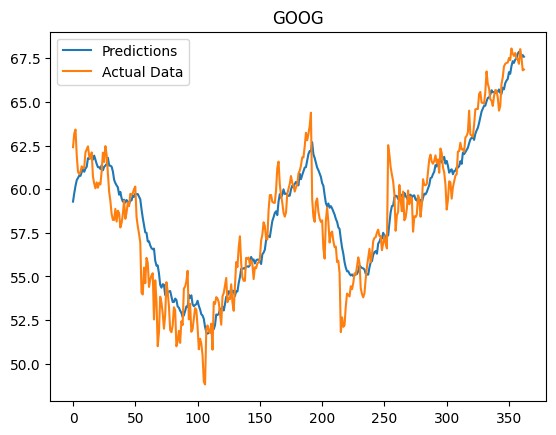

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
pipe = make_pipeline(MinMaxScaler(),Lasso())
tscv = TimeSeriesSplit(n_splits=10)
sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=15,scoring='neg_root_mean_squared_error')
sfs.fit(X_train,y_train)
X_train = sfs.transform(X_train)
pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
pipmodel.fit(X_train,y_train)
X_test =  sfs.transform(X_test)
y_pred = pipmodel.predict(X_test)
print(mse(y_pred, y_test), mse(y_train, pipmodel.predict(X_train)))
plt.plot(y_pred,label="Predictions")
plt.plot(y_test,label="Actual Data")
plt.title(stock)
plt.legend()